<a href="https://colab.research.google.com/github/abragroup/AI-Course-finance-demo-alibaba/blob/master/Stock-Price-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("BABA", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,94.809998,91.639999,91.910004,94.370003,16821500,94.370003
2017-01-06,94.500000,93.000000,94.400002,93.889999,7639800,93.889999
2017-01-09,95.650002,93.309998,94.160004,94.720001,10829500,94.720001
2017-01-10,97.903999,95.550003,96.400002,96.750000,14780600,96.750000
2017-01-11,97.449997,95.599998,96.919998,96.940002,8735900,96.940002


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=20).mean()

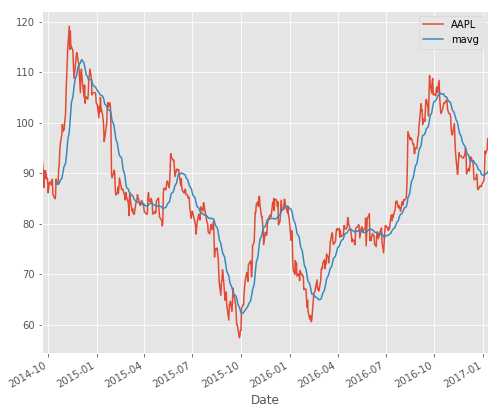

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=( 8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

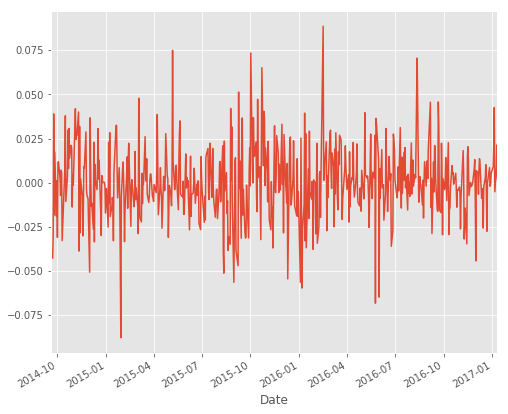

In [4]:
rets = close_px / close_px.shift (1) - 1 
rets.plot (label = 'return')

In [5]:
#compare competitors
dfcomp = web.DataReader(['BABA', 'GOOG', 'IBM', 'MSFT', 'VOD'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,BABA,GOOG,IBM,MSFT,VOD
Date,,,,,
2017-01-05,94.370003,794.020020,150.013260,59.230362,22.409739
2017-01-06,93.889999,806.150024,150.751312,59.743763,22.350094
2017-01-09,94.720001,806.650024,149.079559,59.553616,21.796242
2017-01-10,96.750000,804.789978,147.185501,59.534603,22.179678
2017-01-11,96.940002,807.909973,149.168472,60.076519,22.597200


In [6]:
#correlate the result of competitors inm percent
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.tail()

Symbols,BABA,GOOG,IBM,MSFT,VOD
Symbols,,,,,
BABA,1.000000,0.358860,0.240953,0.344480,0.321735
GOOG,0.358860,1.000000,0.403014,0.472083,0.360032
IBM,0.240953,0.403014,1.000000,0.496674,0.415707
MSFT,0.344480,0.472083,0.496674,1.000000,0.414034
VOD,0.321735,0.360032,0.415707,0.414034,1.000000


Text(0, 0.5, 'Returns BABA')

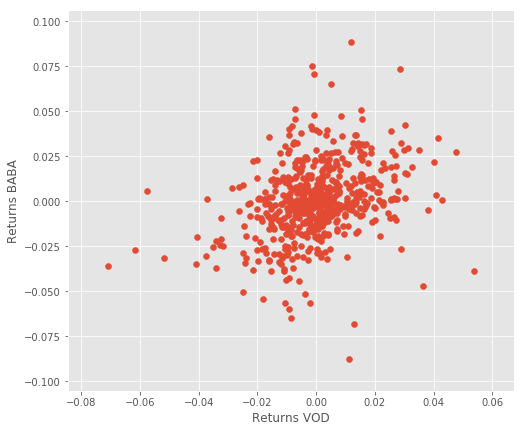

In [7]:
plt.scatter(retscomp.VOD, retscomp.BABA)
plt.xlabel("Returns VOD")
plt.ylabel("Returns BABA")

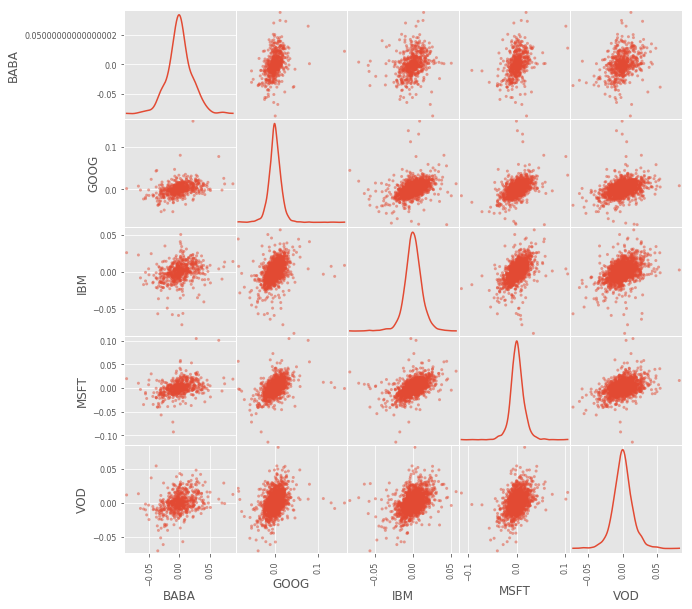

In [8]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));


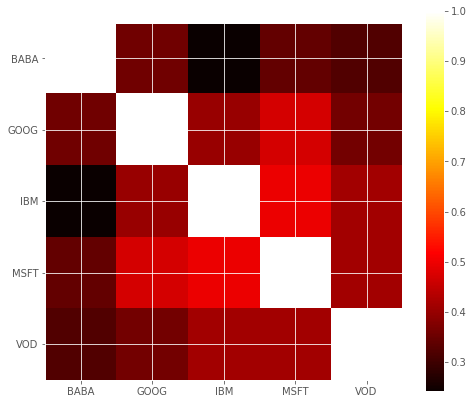

In [9]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

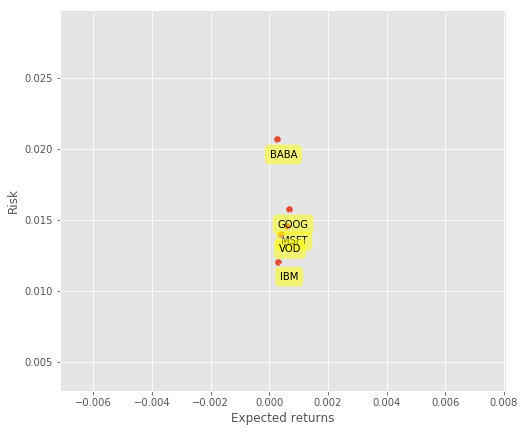

In [10]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
    )

In [11]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2017-01-05,94.370003,16821500,3.359116,2.676530
2017-01-06,93.889999,7639800,1.597614,-0.540256
2017-01-09,94.720001,10829500,2.470443,0.594730
2017-01-10,96.750000,14780600,2.433071,0.363069
2017-01-11,96.940002,8735900,1.908395,0.020640


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
#import sklearn.preprocessing
from sklearn import preprocessing
import numpy as np


#Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [14]:
X_train = pd.DataFrame(X, dtype=object)
y_train = pd.DataFrame(y, dtype=object)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [15]:
clfknn = KNeighborsRegressor (n_neighbors = 2) 
clfknn.fit (X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.25)

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
print("The linear regression confidence is ", confidencereg)
print("The quadratic regression 2 confidence is ", confidencepoly2)
print("The quadratic regression 3 confidence is ", confidencepoly3)
print("The knn regression confidence is ", confidenceknn)

The linear regression confidence is  0.8725026576955344
The quadratic regression 2 confidence is  0.8729745888786842
The quadratic regression 3 confidence is  0.8809636552153384
The knn regression confidence is  0.9364254503679673


In [0]:
#from sklearn.tree import DecisionTreeClassifier
#clf = DecisionTreeClassifier()
#clf = clf.fit(X, y)
#forecast_set = clf.predict(X_lately)
#dfreg['Forecast'] = np.nan

#print(forecast_set)